<a href="https://colab.research.google.com/github/dcher95/alexandria-library/blob/master/pytorch/zero_to_mastery/04_pytorch_custom_datasets-exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

In [1]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.0+cu121


'cuda'

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [2]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [3]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

walk_through_dir(train_dir)
walk_through_dir(test_dir)

There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


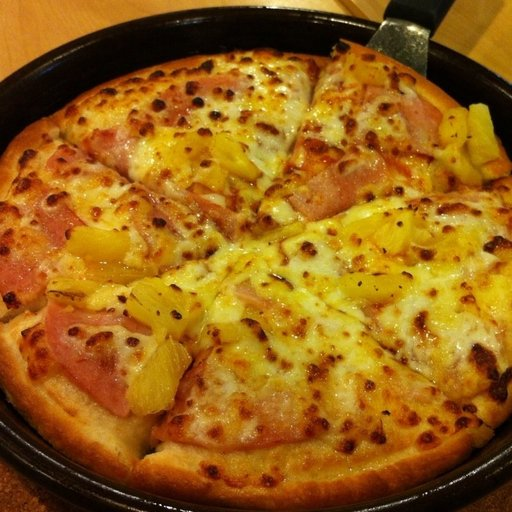

In [5]:
# Visualize an image
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob(f"*/*/*.jpg"))
img = Image.open(random.choice(image_path_list))
img


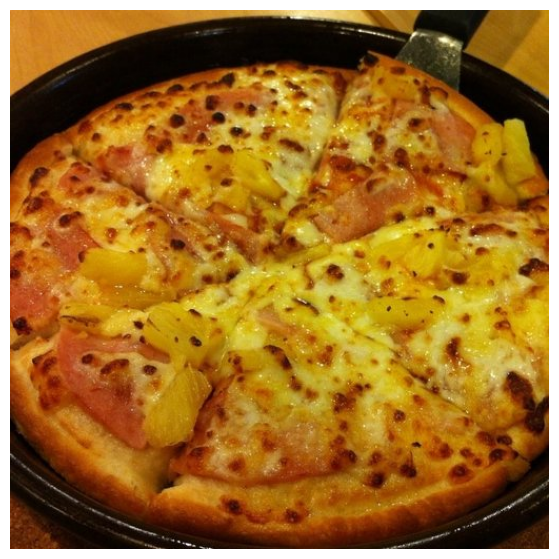

In [6]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_array)
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [7]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [8]:
# Write transform for turning images into tensors
tensor_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

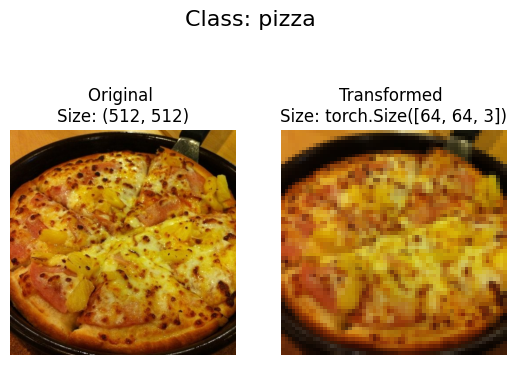

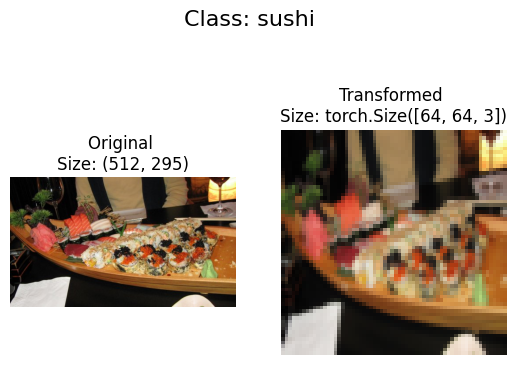

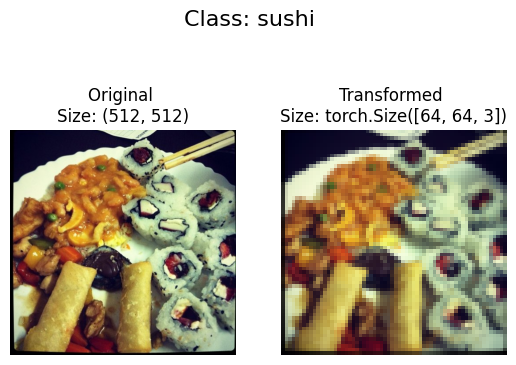

In [9]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """Plots random images from image_paths."""
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
      with Image.open(image_path) as f:
          fig, ax = plt.subplots(1, 2)
          ax[0].imshow(f)
          ax[0].set_title(f"Original \nSize: {f.size}")
          ax[0].axis("off")

          # Transform and plot image
          # Note: permute() will change shape of image to suit matplotlib
          # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
          transformed_image = transform(f).permute(1, 2, 0)
          ax[1].imshow(transformed_image)
          ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
          ax[1].axis("off")

          fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=tensor_transform,
                        n=3)

### Load image data using `ImageFolder`

In [10]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [11]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [12]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [13]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [14]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=16, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=16,
                             num_workers=os.cpu_count(),
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a56dbf35360>,
 <torch.utils.data.dataloader.DataLoader at 0x7a56dbf35090>)

In [15]:
# How many batches of images are in our data loaders?
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [16]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [17]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
input_size = [32, 3, 64, 64]  # batch size 32, 3 channels, 224x224 image size

# Use torchinfo to get a summary of the model

summary(model_0, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

## 4. Create training and testing functions for `model_0`.

In [18]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X,y) in enumerate(dataloader):

    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)


  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [19]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():

    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):

      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [20]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [21]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

model5 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model5.parameters(),
                             lr=0.001)

model_0_results5 = train(model=model5,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=5)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1077 | train_acc: 0.2708 | test_loss: 1.1276 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.0957 | train_acc: 0.3833 | test_loss: 1.1169 | test_acc: 0.2375
Epoch: 3 | train_loss: 1.0979 | train_acc: 0.3125 | test_loss: 1.1054 | test_acc: 0.2500
Epoch: 4 | train_loss: 1.0540 | train_acc: 0.4958 | test_loss: 1.0321 | test_acc: 0.4341
Epoch: 5 | train_loss: 0.9195 | train_acc: 0.5833 | test_loss: 1.0310 | test_acc: 0.4045
Total training time: 10.485 seconds


In [22]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

model20 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model20.parameters(),
                             lr=0.001)

model_0_results20 = train(model=model20,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1077 | train_acc: 0.2708 | test_loss: 1.1276 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.0957 | train_acc: 0.3833 | test_loss: 1.1169 | test_acc: 0.2375
Epoch: 3 | train_loss: 1.0977 | train_acc: 0.3125 | test_loss: 1.1045 | test_acc: 0.2625
Epoch: 4 | train_loss: 1.0527 | train_acc: 0.4833 | test_loss: 1.0319 | test_acc: 0.4341
Epoch: 5 | train_loss: 0.9262 | train_acc: 0.5958 | test_loss: 1.0373 | test_acc: 0.3682
Epoch: 6 | train_loss: 0.8878 | train_acc: 0.6167 | test_loss: 1.0737 | test_acc: 0.5216
Epoch: 7 | train_loss: 0.8968 | train_acc: 0.5833 | test_loss: 0.9877 | test_acc: 0.4545
Epoch: 8 | train_loss: 0.8056 | train_acc: 0.5875 | test_loss: 0.9884 | test_acc: 0.5341
Epoch: 9 | train_loss: 0.7628 | train_acc: 0.6750 | test_loss: 1.0071 | test_acc: 0.5273
Epoch: 10 | train_loss: 0.7649 | train_acc: 0.7042 | test_loss: 1.0721 | test_acc: 0.5159
Epoch: 11 | train_loss: 0.6973 | train_acc: 0.7083 | test_loss: 1.0067 | test_acc: 0.4659
Epoch: 12 | train_l

In [23]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

model50 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model50.parameters(),
                             lr=0.001)

model_0_results50 = train(model=model50,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=50)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1077 | train_acc: 0.2708 | test_loss: 1.1276 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.0957 | train_acc: 0.3833 | test_loss: 1.1169 | test_acc: 0.2375
Epoch: 3 | train_loss: 1.0980 | train_acc: 0.3125 | test_loss: 1.1070 | test_acc: 0.2500
Epoch: 4 | train_loss: 1.0530 | train_acc: 0.4875 | test_loss: 1.0273 | test_acc: 0.4648
Epoch: 5 | train_loss: 0.9169 | train_acc: 0.5792 | test_loss: 1.0331 | test_acc: 0.4170
Epoch: 6 | train_loss: 0.8875 | train_acc: 0.6250 | test_loss: 1.1053 | test_acc: 0.5341
Epoch: 7 | train_loss: 0.9044 | train_acc: 0.5833 | test_loss: 0.9968 | test_acc: 0.4170
Epoch: 8 | train_loss: 0.8114 | train_acc: 0.5875 | test_loss: 0.9904 | test_acc: 0.4966
Epoch: 9 | train_loss: 0.7742 | train_acc: 0.6792 | test_loss: 1.0042 | test_acc: 0.4966
Epoch: 10 | train_loss: 0.7692 | train_acc: 0.6958 | test_loss: 1.0780 | test_acc: 0.4898
Epoch: 11 | train_loss: 0.7142 | train_acc: 0.7000 | test_loss: 0.9841 | test_acc: 0.4659
Epoch: 12 | train_l

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [24]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed(42)


from timeit import default_timer as timer
start_time = timer()

model_2x = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=20,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2x.parameters(),
                             lr=0.001)

model_0_results20 = train(model=model_2x,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0981 | train_acc: 0.4083 | test_loss: 1.0911 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.1087 | train_acc: 0.3917 | test_loss: 1.0999 | test_acc: 0.3375
Epoch: 3 | train_loss: 1.0960 | train_acc: 0.3625 | test_loss: 1.0881 | test_acc: 0.3375
Epoch: 4 | train_loss: 1.0625 | train_acc: 0.4500 | test_loss: 1.0587 | test_acc: 0.3182
Epoch: 5 | train_loss: 0.8875 | train_acc: 0.5958 | test_loss: 1.0336 | test_acc: 0.4614
Epoch: 6 | train_loss: 0.9473 | train_acc: 0.5167 | test_loss: 1.1066 | test_acc: 0.4182
Epoch: 7 | train_loss: 0.8802 | train_acc: 0.5792 | test_loss: 0.9753 | test_acc: 0.5148
Epoch: 8 | train_loss: 0.8123 | train_acc: 0.6542 | test_loss: 1.0314 | test_acc: 0.4614
Epoch: 9 | train_loss: 0.7917 | train_acc: 0.6458 | test_loss: 0.9888 | test_acc: 0.5341
Epoch: 10 | train_loss: 0.7541 | train_acc: 0.6708 | test_loss: 1.1359 | test_acc: 0.4295
Epoch: 11 | train_loss: 0.7209 | train_acc: 0.6917 | test_loss: 1.0677 | test_acc: 0.4659
Epoch: 12 | train_l

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [25]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [26]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.


Excellent, we now have double the training and testing images...

In [27]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [28]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20 = datasets.ImageFolder(train_data_20_percent_path, transform=simple_transform)
test_data_20 = datasets.ImageFolder(test_data_20_percent_path, transform=simple_transform)


# Create dataloaders
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_20 = DataLoader(train_data_20,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_20 = DataLoader(test_data_20,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [30]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed(42)


from timeit import default_timer as timer
start_time = timer()

model_20_2 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_20_2.parameters(),
                             lr=0.001)

model_1_results = train(model=model_20_2,
                        train_dataloader=train_dataloader_20,
                        test_dataloader=test_dataloader_20,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1111 | train_acc: 0.3039 | test_loss: 1.0974 | test_acc: 0.3625
Epoch: 2 | train_loss: 1.0985 | train_acc: 0.3168 | test_loss: 1.0909 | test_acc: 0.4875
Epoch: 3 | train_loss: 1.0530 | train_acc: 0.5022 | test_loss: 0.9760 | test_acc: 0.4729
Epoch: 4 | train_loss: 0.9343 | train_acc: 0.5086 | test_loss: 0.9482 | test_acc: 0.5354
Epoch: 5 | train_loss: 0.8863 | train_acc: 0.5690 | test_loss: 0.9928 | test_acc: 0.4917
Epoch: 6 | train_loss: 0.8856 | train_acc: 0.5754 | test_loss: 0.9517 | test_acc: 0.5312
Epoch: 7 | train_loss: 0.8736 | train_acc: 0.6078 | test_loss: 0.9160 | test_acc: 0.5792
Epoch: 8 | train_loss: 0.8459 | train_acc: 0.6638 | test_loss: 0.9114 | test_acc: 0.5958
Epoch: 9 | train_loss: 0.8163 | train_acc: 0.6638 | test_loss: 0.9169 | test_acc: 0.6021
Epoch: 10 | train_loss: 0.8347 | train_acc: 0.6401 | test_loss: 0.9019 | test_acc: 0.5771
Epoch: 11 | train_loss: 0.8171 | train_acc: 0.6595 | test_loss: 0.9249 | test_acc: 0.5979
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [31]:
import torchvision
# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

data/04-pizza-dad.jpeg already exists, skipping download.


In [34]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

model_20_2.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_20_2(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [35]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.7324, -1.8407, -1.4639]], device='cuda:0')
Prediction probabilities: tensor([[0.8421, 0.0643, 0.0937]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')
